## Classification of  Predicted Control Yield


### 1. Control Yield Prediction

In [2]:
library(rgdal)
library(raster)
library(gstat)
source("colMeans_new.R")
library(ggplot2)

Warning message:
: package ‘rgdal’ was built under R version 3.2.5Loading required package: sp
Warning message:
: package ‘sp’ was built under R version 3.2.5rgdal: version: 1.1-10, (SVN revision 622)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.11.4, released 2016/01/25
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rgdal/gdal
 Loaded PROJ.4 runtime: Rel. 4.9.1, 04 March 2015, [PJ_VERSION: 491]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rgdal/proj
 Linking to sp version: 1.2-3 
Warning message:
: package ‘raster’ was built under R version 3.2.5Warning message:
: package ‘gstat’ was built under R version 3.2.4Warning message:
: package ‘ggplot2’ was built under R version 3.2.4

#### 1.1 Load in data

All of the data are shared at
https://www.dropbox.com/s/soginipadvyggka/data.zip?dl=0

Please unzip this archive in the same folder that contains the code.

In [3]:
tamasa_data <- read.csv("data/maize_yield.csv", stringsAsFactors=FALSE)
dryyield_perplot <- aggregate(cbind(tamasa_data$grain_dry_wt_subsample..g., tamasa_data$gps_longitude, tamasa_data$gps_latitude), by=list(tamasa_data$plotID), colMeans)
dryyield_perplot <- na.omit(dryyield_perplot)
names(dryyield_perplot) <- c("fieldID", "avg_dryweight", "longitude", "latitude")

#### 1.2 Extract remote sensing covariates
The spatial resolutions of those covariates are all 1km-by-1km
* CTI: Average compound topographic index;
* PH: predicted top soil PH from legacy data;
* SOC: predicted top soil SOC from legacy data;
* EVIA: Long-term average (2000–2014) average enhanced vegetation index;
* fPARs: Long-term average (2000–2014) fraction of absorbed photosynthetically active radiation;
* TMAPs: Long-term (1998–2013) mean annual precipitation;
* TMFIs: Long-term (1998–2013) average modified Fournier (rainfall aggressiveness) index. 

In [4]:
loc_laea <- project(cbind(dryyield_perplot$longitude, dryyield_perplot$latitude), "+proj=laea +ellps=WGS84 +lon_0=20 +lat_0=5 +units=m +no_defs")
tiffiles <- list.files("data/tif", pattern="tif", full.name=TRUE)
tiffiles

[1] "data/tif/CTIs.tif"                 "data/tif/depth.10.ph.mean.TZ.tif" 
[3] "data/tif/depth.10.soc.mean.TZ.tif" "data/tif/EVIAs.tif"               
[5] "data/tif/fPARs.tif"                "data/tif/TMAPs.tif"               
[7] "data/tif/TMFIs.tif"

In [4]:
remotesensing_files <- stack(tiffiles)
remotesensing_cov <- extract( remotesensing_files,loc_laea)
dryyield_perplot_withcov <- cbind(dryyield_perplot, remotesensing_cov)
names(dryyield_perplot_withcov)[6] <- "PH"
names(dryyield_perplot_withcov)[7] <- "SOC"
dryyield_perplot_withcov <- dryyield_perplot_withcov[, -c(1, 3, 4)]
str(dryyield_perplot_withcov)

'data.frame':	101 obs. of  8 variables:
 $ avg_dryweight: num  455 311 1057 443 438 ...
 $ CTIs         : num  0.5851 -0.7508 -0.1369 0.0773 -0.7767 ...
 $ PH           : num  6.06 5.56 5.92 6.02 5.27 ...
 $ SOC          : num  21.3 38.4 24.1 26 45.7 ...
 $ EVIAs        : num  0.609 0.628 0.541 0.342 1.277 ...
 $ fPARs        : num  0.0529 0.2093 0.1768 -0.0113 0.4449 ...
 $ TMAPs        : num  0.385 0.991 0.661 0.365 1.081 ...
 $ TMFIs        : num  0.672 1.275 0.993 0.608 1.235 ...


#### 1.3 Estimate a linear model
The model does not fit so well due to the small size of the dataset. It might be worthwhile trying this with remote sensing covariates that have higher resolution.

In [5]:
lm_test <- lm(log(avg_dryweight)~., data=dryyield_perplot_withcov)

summary(lm_test)


Call:
lm(formula = log(avg_dryweight) ~ ., data = dryyield_perplot_withcov)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.80460 -0.26155  0.02691  0.36612  1.05987 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  5.784278   2.210464   2.617  0.01036 * 
CTIs        -0.197742   0.198562  -0.996  0.32190   
PH           0.103081   0.355709   0.290  0.77262   
SOC         -0.014498   0.007216  -2.009  0.04743 * 
EVIAs       -0.081187   0.271925  -0.299  0.76594   
fPARs        0.195978   0.282824   0.693  0.49008   
TMAPs        1.457691   0.492967   2.957  0.00394 **
TMFIs       -1.030458   0.349562  -2.948  0.00405 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5444 on 93 degrees of freedom
Multiple R-squared:  0.1377,	Adjusted R-squared:  0.07281 
F-statistic: 2.122 on 7 and 93 DF,  p-value: 0.0487


### 2. Control yield prediction

#### Extract prediction covariates using geosurvey cropland prediction mask

In [6]:
crp_map <- readGDAL("data/TZ_crp_ens_1k.tif")
coordinates_crplocs <- coordinates(crp_map)[!is.na(crp_map@data$band1), ]
crpdata <- crp_map@data$band1[!is.na(crp_map@data$band1)]
coordinates_crplocs <- coordinates_crplocs[crpdata>0.51, ]
predict_cov <- extract(remotesensing_files, coordinates_crplocs)

data/TZ_crp_ens_1k.tif has GDAL driver GTiff 
and has 1192 rows and 1211 columns


In [7]:
predict_cov <- as.data.frame(predict_cov)
names(predict_cov)[2] <- "PH"
names(predict_cov)[3] <- "SOC"

predicted_values <- predict(lm_test, predict_cov)

predicted_values_withcov <- data.frame(predicted_values = exp(predicted_values), x= coordinates_crplocs[,1], y=coordinates_crplocs[,2])
predicted_values_withcov <- na.omit(predicted_values_withcov)

coordinates(predicted_values_withcov)  =~x+y
predicted_values_withcov@proj4string@projargs <- " +proj=laea +lat_0=5 +lon_0=20 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs"

gridded(predicted_values_withcov) <- TRUE
writeGDAL (
  dataset=predicted_values_withcov["predicted_values"],
  fname="dryweight_predicted.tif",
  drivername= "GTiff",
  type="Float32")


Warning message:
In points2grid(points, tolerance, round): grid has empty column/rows in dimension 1Warning message:
In points2grid(points, tolerance, round): grid has empty column/rows in dimension 2

### Aggregate the prediction map to 10km-by-10km

In [8]:
GID <- function(location, res.pixel){
    xgid <- floor(location[,1]/res.pixel)
    ygid <- floor(location[,2]/res.pixel)
    gidx <- ifelse(location[,1]<0, paste("W", abs(xgid), sep=""), paste("E", abs(xgid), sep=""))
    gidy <- ifelse(location[,2]<0, paste("S", abs(ygid), sep=""), paste("N", abs(ygid), sep=""))
    GID <- paste(gidx, gidy, sep="-")
    return(list(xgid=xgid, ygid=ygid, GID=GID))
}


GID_10K <- GID(coordinates(predicted_values_withcov), 10000)
coords_GID10K <- data.frame(x = GID_10K[[1]]*10000, y=GID_10K[[2]]*10000, GID=GID_10K[[3]])

predicted_values_10K <- aggregate(predicted_values_withcov@data$predicted_values, by=list(coords_GID10K[,3]), mean)
GID_10K_coord <- aggregate(cbind(coords_GID10K$x, coords_GID10K$y), by=list(coords_GID10K[,3]), colMeans)
predicted_values_10K <- merge(predicted_values_10K, GID_10K_coord, by='Group.1')
str(predicted_values_10K)

'data.frame':	5539 obs. of  4 variables:
 $ Group.1: Factor w/ 5539 levels "E106-S108","E106-S109",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ x      : num  656 728 657 533 518 ...
 $ V1     : num  1060000 1060000 1060000 1070000 1070000 1070000 1070000 1070000 1070000 1080000 ...
 $ V2     : num  -1080000 -1090000 -1100000 -1050000 -1060000 -1070000 -1080000 -1090000 -1100000 -1040000 ...


#### k-means clustering for the control yield predictions on 10km-by-10km

In [9]:
kmeans_10K <- kmeans(predicted_values_10K$x,centers=5)
kmeans_10K$centers

[,1]
1 1190.8801
2  395.2944
3 1873.2672
4  561.7193
5  783.0082

In [10]:
names(predicted_values_10K) <- c("GID_10K", "predicted_Values", "x", "y")
predicted_values_10K$predicted_10k_cat <- kmeans_10K$cluster
coordinates(predicted_values_10K)  =~x+y
predicted_values_10K@proj4string@projargs <- " +proj=laea +lat_0=5 +lon_0=20 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs"


gridded(predicted_values_10K) <- TRUE

writeGDAL (
  dataset=predicted_values_10K["predicted_10k_cat"],
  fname="dryweight_predicted_cat_10k.tif",
  drivername= "GTiff",
  type="Float32")

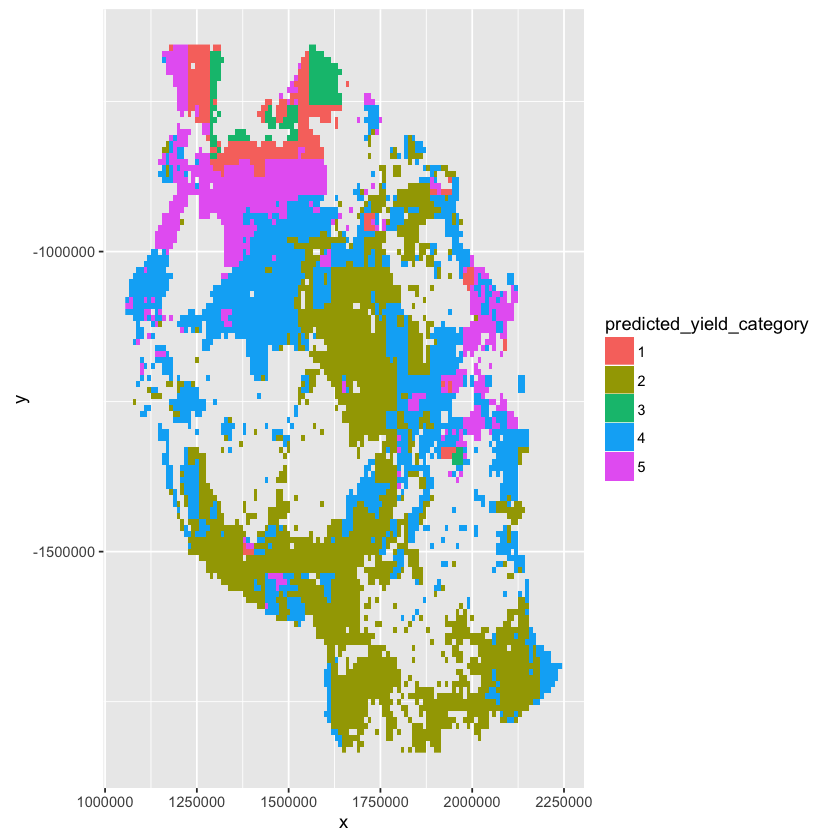

In [11]:
yield_map <- raster("dryweight_predicted_cat_10k.tif")
map.p <- rasterToPoints(yield_map)
df <- data.frame(map.p)
names(df) <- c("x", "y", "predicted_yield_category")
df$predicted_yield_category <- as.factor(df$predicted_yield_category)
ggplot(data=df, aes(y=y, x=x), color='green') + geom_raster(aes(fill=predicted_yield_category)) 

In [28]:
yield_map_vec <- rasterToPolygons(yield_map,  dissolve=TRUE)

Loading required namespace: rgeos


In [30]:
writeOGR(yield_map_vec, "TZ_crp_1k/", "TZ_crp_10k",driver="ESRI Shapefile", overwrite_layer=TRUE)

Warning message:
In writeOGR(yield_map_vec, "TZ_crp_1k/", "TZ_crp_10k", driver = "ESRI Shapefile", : Field names abbreviated for ESRI Shapefile driver